<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/AUGMENTATION_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

In [20]:
img_dim=64
transform = transforms.Compose(
    [transforms.RandomRotation(180),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Resize(size=img_dim,interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


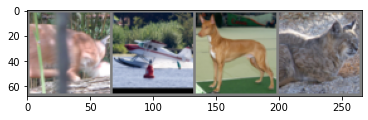

  cat airplane   dog   cat


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.hidden_size * 4 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10),
            nn.Softmax(dim=1),
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [23]:
hidden_size=32
channels_size=3

net=CNN(hidden_size, channels_size)

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=8192, out_featu

In [26]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')
PATH = './stl10_net.pth'
torch.save(net.state_dict(), PATH)

[1,   200] loss: 2.251
[1,   400] loss: 2.151
[1,   600] loss: 2.107
[1,   800] loss: 2.125
[1,  1000] loss: 2.083
[1,  1200] loss: 2.083
[2,   200] loss: 2.044
[2,   400] loss: 2.060
[2,   600] loss: 2.069
[2,   800] loss: 2.052
[2,  1000] loss: 2.051
[2,  1200] loss: 2.047
[3,   200] loss: 2.011
[3,   400] loss: 1.989
[3,   600] loss: 2.013
[3,   800] loss: 2.001
[3,  1000] loss: 2.001
[3,  1200] loss: 2.023
[4,   200] loss: 1.999
[4,   400] loss: 1.969
[4,   600] loss: 1.986
[4,   800] loss: 1.951
[4,  1000] loss: 1.960
[4,  1200] loss: 1.996
[5,   200] loss: 1.933
[5,   400] loss: 1.939
[5,   600] loss: 1.946
[5,   800] loss: 1.951
[5,  1000] loss: 1.932
[5,  1200] loss: 1.980
[6,   200] loss: 1.945
[6,   400] loss: 1.967
[6,   600] loss: 1.920
[6,   800] loss: 1.937
[6,  1000] loss: 1.918
[6,  1200] loss: 1.930
[7,   200] loss: 1.908
[7,   400] loss: 1.930
[7,   600] loss: 1.920
[7,   800] loss: 1.906
[7,  1000] loss: 1.920
[7,  1200] loss: 1.904
[8,   200] loss: 1.871
[8,   400] 

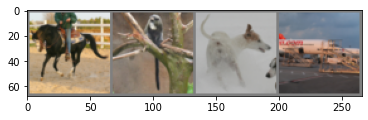

GroundTruth:  horse monkey   dog airplane


In [27]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 78 %
Accuracy of  bird : 48 %
Accuracy of   car : 75 %
Accuracy of   cat : 47 %
Accuracy of  deer : 54 %
Accuracy of   dog : 29 %
Accuracy of horse : 61 %
Accuracy of monkey : 54 %
Accuracy of  ship : 80 %
Accuracy of truck : 65 %
